In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm
import copy
import random
import hashlib

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: SkinLesionDataset (Unchanged)
class SkinLesionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = []
        self.labels = []
        
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                self.images.append(os.path.join(cls_dir, img_name))
                self.labels.append(self.class_to_idx[cls_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [3]:
# Cell 3: Data Loading and Deduplication (Unchanged)
base_path = "/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS"

all_images = []
all_labels = []

for fold in range(1, 6):
    train_path = os.path.join(base_path, f"fold{fold}", "Train")
    for class_name in os.listdir(train_path):
        class_path = os.path.join(train_path, class_name)
        for img_name in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img_name))
            all_labels.append(class_name)

df = pd.DataFrame({'image_path': all_images, 'label': all_labels})

print("Creating image hashes...")
tqdm.pandas()
df['content_hash'] = df['image_path'].progress_apply(
    lambda x: hashlib.md5(open(x,'rb').read()).hexdigest()
)

print(f"\nOriginal dataset size: {len(df)}")
df_clean = df.drop_duplicates(subset=['content_hash'], keep='first')
print(f"After removing duplicates: {len(df_clean)}")

print("\nClass distribution after cleaning:")
print(df_clean['label'].value_counts().sort_index())

Creating image hashes...


100%|██████████| 2646/2646 [00:15<00:00, 174.86it/s]



Original dataset size: 2646
After removing duplicates: 754

Class distribution after cleaning:
label
Chickenpox     74
Cowpox         66
HFMD          161
Healthy       114
Measles        55
Monkeypox     284
Name: count, dtype: int64


In [4]:
# Cell 4: Data Splitting (Unchanged)
train_val, test = train_test_split(
    df_clean, 
    test_size=0.1, 
    stratify=df_clean['label'], 
    random_state=42
)
train, val = train_test_split(
    train_val, 
    test_size=0.2222,
    stratify=train_val['label'], 
    random_state=42
)

print(f"\nSplit sizes:")
print(f"Train (pre-aug): {len(train)} samples")
print(f"Val: {len(val)} samples")
print(f"Test: {len(test)} samples")

def verify_no_overlap(set1, set2):
    set1_hashes = set(set1['content_hash'])
    set2_hashes = set(set2['content_hash'])
    return len(set1_hashes & set2_hashes)

print("\nOverlap verification:")
print(f"Train-Val: {verify_no_overlap(train, val)} duplicates")
print(f"Train-Test: {verify_no_overlap(train, test)} duplicates")
print(f"Val-Test: {verify_no_overlap(val, test)} duplicates")



Split sizes:
Train (pre-aug): 527 samples
Val: 151 samples
Test: 76 samples

Overlap verification:
Train-Val: 0 duplicates
Train-Test: 0 duplicates
Val-Test: 0 duplicates


In [5]:
# Cell 5: Class-Specific Data Transforms
from torchvision import transforms

# Enhanced augmentation for Chickenpox
chickenpox_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),  # Wider crop range for diversity
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.25),  # Stronger color variation
    transforms.RandomRotation(60),  # Increased rotation range
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.7, 1.3)),  # More aggressive affine
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.75, scale=(0.03, 0.2), ratio=(0.2, 4.0))  # Higher erasing probability
])

# Enhanced augmentation for Cowpox (further refined)
cowpox_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),  # Even wider crop range
    transforms.RandomHorizontalFlip(p=0.6),  # Slightly higher flip probability
    transforms.RandomVerticalFlip(p=0.6),  # Slightly higher flip probability
    transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.35),  # More aggressive color jitter
    transforms.RandomRotation(75),  # Further increased rotation
    transforms.RandomAffine(degrees=0, translate=(0.25, 0.25), scale=(0.65, 1.35)),  # More aggressive affine
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.85, scale=(0.04, 0.25), ratio=(0.15, 4.5))  # More aggressive erasing
])

# Standard augmentation for other classes
standard_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3))
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_transforms = {
    'train': {
        'Chickenpox': chickenpox_transforms,
        'Cowpox': cowpox_transforms,
        'default': standard_transforms
    },
    'val': val_test_transforms,
    'test': val_test_transforms
}


In [6]:
# Cell 6: Dataset Classes with Aggressive Oversampling
from torch.utils.data import Dataset
from PIL import Image
import torch

class CustomSplitDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(dataframe['label'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'image_path']
        label = self.dataframe.loc[idx, 'label']
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.class_to_idx[label]
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            return self.__getitem__(torch.randint(0, len(self), (1,)).item())

class AugmentedDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_counts=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(dataframe['label'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.target_counts = target_counts or int(dataframe['label'].value_counts().max() * 3.0)  # 3x oversampling
        self.augment_per_image = self._calculate_augmentation_factors()
        
    def _calculate_augmentation_factors(self):
        class_counts = self.dataframe['label'].value_counts()
        return {
            cls: max(1, (self.target_counts // count) - 1)
            for cls, count in class_counts.items()
            if count < self.target_counts
        }
    
    def __len__(self):
        original_size = len(self.dataframe)
        if not self.augment_per_image:
            return original_size
        return original_size + sum(
            self.augment_per_image.get(cls, 0) * len(self.dataframe[self.dataframe['label'] == cls])
            for cls in self.classes
        )
    
    def __getitem__(self, idx):
        original_size = len(self.dataframe)
        if idx < original_size:
            sample = self.dataframe.iloc[idx]
        else:
            cls_idx = (idx - original_size) % len(self.classes)
            cls = self.classes[cls_idx]
            if cls in self.augment_per_image:
                cls_samples = self.dataframe[self.dataframe['label'] == cls]
                sample = cls_samples.iloc[(idx - original_size) // len(self.classes) % len(cls_samples)]
            else:
                sample = self.dataframe.iloc[idx % original_size]
        
        img = Image.open(sample['image_path']).convert('RGB')
        label = sample['label']
        
        transform = self.transform.get(label, self.transform['default']) if isinstance(self.transform, dict) else self.transform
        if idx >= original_size and label in self.augment_per_image:
            img = transform(img)
        else:
            img = transforms.Resize(256)(img)
            img = transforms.CenterCrop(224)(img)
            img = transforms.ToTensor()(img)
            img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
            
        return img, self.class_to_idx[label]

train_dataset = AugmentedDataset(
    train, 
    transform=data_transforms['train'],
    target_counts=int(train['label'].value_counts().max() * 3.0)
)

val_dataset = CustomSplitDataset(val, transform=data_transforms['val'])
test_dataset = CustomSplitDataset(test, transform=data_transforms['test'])

print("\nFinal dataset sizes:")
print(f"Train (post-aug): {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")
print("\nClass distribution in augmented training set:")
print(train_dataset.dataframe['label'].value_counts())



Final dataset sizes:
Train (post-aug): 3413 samples
Val: 151 samples
Test: 76 samples

Class distribution in augmented training set:
label
Monkeypox     198
HFMD          113
Healthy        80
Chickenpox     52
Cowpox         46
Measles        38
Name: count, dtype: int64


In [7]:
# Cell 7: Data Loaders (Unchanged)
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    persistent_workers=True
)

print("\nData loading ready! Augmentation only applied to training set.")


Data loading ready! Augmentation only applied to training set.


In [8]:
import torch
import torch.nn as nn
from torchvision import models

class EnhancedDotAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        B, C, H, W = x.size()
        
        # Compute query, key, value
        q = self.query(x).view(B, C, H * W)  # [B, C, H*W]
        k = self.key(x).view(B, C, H * W)    # [B, C, H*W]
        v = self.value(x).view(B, C, H * W)  # [B, C, H*W]
        
        # Dot-product attention
        attention = torch.bmm(q.transpose(1, 2), k)  # [B, H*W, H*W]
        attention = attention / (C ** 0.5 + 1e-8)   # Scale by sqrt of channel dimension
        attention = torch.clamp(attention, -1e4, 1e4)  # Prevent overflow
        attention = self.softmax(attention)
        attention = self.dropout(attention)
        
        # Apply attention to values
        out = torch.bmm(v, attention)  # [B, C, H*W]
        out = out.view(B, C, H, W)     # Reshape back to [B, C, H, W]
        
        return self.gamma * out + x

class MpoxCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        for param in self.base_model.parameters():
            param.requires_grad = True
        
        in_features = self.base_model.fc.in_features
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])
        
        self.attention = EnhancedDotAttention(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.attention(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]



=== Stage 1: Minority Class Focus ===

Epoch 0/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


Train Loss: 0.8633 | Acc: 0.4354
Val Loss: 0.1826 | Acc: 0.7219

Epoch 1/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.85it/s]


Train Loss: 0.3218 | Acc: 0.6967
Val Loss: 0.1537 | Acc: 0.8013

Epoch 2/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.21it/s]


Train Loss: 0.1918 | Acc: 0.7961
Val Loss: 0.0763 | Acc: 0.8146

Epoch 3/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.15it/s]


Train Loss: 0.1507 | Acc: 0.8494
Val Loss: 0.0648 | Acc: 0.8742

Epoch 4/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.78it/s]


Train Loss: 0.1122 | Acc: 0.8731
Val Loss: 0.1126 | Acc: 0.8278

Epoch 5/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.98it/s]


Train Loss: 0.0845 | Acc: 0.9021
Val Loss: 0.1107 | Acc: 0.8742

Epoch 6/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.20it/s]


Train Loss: 0.0850 | Acc: 0.8936
Val Loss: 0.1165 | Acc: 0.8212

Epoch 7/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.26it/s]


Train Loss: 0.0636 | Acc: 0.9153
Val Loss: 0.0704 | Acc: 0.8411

Epoch 8/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.59it/s]


Train Loss: 0.0620 | Acc: 0.9241
Val Loss: 0.1310 | Acc: 0.8146

Epoch 9/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.12it/s]


Train Loss: 0.0487 | Acc: 0.9341
Val Loss: 0.0912 | Acc: 0.8477

Epoch 10/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.07it/s]


Train Loss: 0.0383 | Acc: 0.9388
Val Loss: 0.0975 | Acc: 0.8477

Epoch 11/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.95it/s]


Train Loss: 0.0394 | Acc: 0.9455
Val Loss: 0.0913 | Acc: 0.8411

Epoch 12/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.65it/s]


Train Loss: 0.0336 | Acc: 0.9499
Val Loss: 0.0702 | Acc: 0.9007

Epoch 13/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.26it/s]


Train Loss: 0.0362 | Acc: 0.9484
Val Loss: 0.0896 | Acc: 0.8742

Epoch 14/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.92it/s]


Train Loss: 0.0246 | Acc: 0.9596
Val Loss: 0.1436 | Acc: 0.8940

Epoch 15/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.04it/s]


Train Loss: 0.0315 | Acc: 0.9587
Val Loss: 0.0865 | Acc: 0.8742

Epoch 16/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.13it/s]


Train Loss: 0.0229 | Acc: 0.9599
Val Loss: 0.0624 | Acc: 0.8874

Epoch 17/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.17it/s]


Train Loss: 0.0291 | Acc: 0.9561
Val Loss: 0.0769 | Acc: 0.8808

Epoch 18/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.11it/s]


Train Loss: 0.0253 | Acc: 0.9607
Val Loss: 0.0978 | Acc: 0.8675

Epoch 19/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.13it/s]


Train Loss: 0.0189 | Acc: 0.9686
Val Loss: 0.0998 | Acc: 0.8543

Epoch 20/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s]


Train Loss: 0.0214 | Acc: 0.9643
Val Loss: 0.0822 | Acc: 0.8808

Epoch 21/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.26it/s]


Train Loss: 0.0173 | Acc: 0.9716
Val Loss: 0.0810 | Acc: 0.8477

Epoch 22/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.03it/s]


Train Loss: 0.0193 | Acc: 0.9681
Val Loss: 0.0756 | Acc: 0.8742

Epoch 23/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.14it/s]


Train Loss: 0.0143 | Acc: 0.9754
Val Loss: 0.0683 | Acc: 0.8808

Epoch 24/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.11it/s]


Train Loss: 0.0171 | Acc: 0.9716
Val Loss: 0.0877 | Acc: 0.8543

Epoch 25/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.06it/s]


Train Loss: 0.0141 | Acc: 0.9751
Val Loss: 0.0684 | Acc: 0.8808

Epoch 26/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.08it/s]


Train Loss: 0.0113 | Acc: 0.9798
Val Loss: 0.0817 | Acc: 0.8742

Epoch 27/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.16it/s]


Train Loss: 0.0134 | Acc: 0.9739
Val Loss: 0.1023 | Acc: 0.8411

Epoch 28/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.64it/s]


Train Loss: 0.0127 | Acc: 0.9739
Val Loss: 0.0634 | Acc: 0.8609

Epoch 29/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.90it/s]


Train Loss: 0.0115 | Acc: 0.9792
Val Loss: 0.0537 | Acc: 0.8675

Epoch 30/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.16it/s]


Train Loss: 0.0164 | Acc: 0.9810
Val Loss: 0.0667 | Acc: 0.8675

Epoch 31/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.01it/s]


Train Loss: 0.0161 | Acc: 0.9783
Val Loss: 0.0571 | Acc: 0.8940

Epoch 32/49 (minority)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.16it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.0082 | Acc: 0.9848
Val Loss: 0.0589 | Acc: 0.8940

Early stopping triggered after 33 epochs
Best validation Acc (minority): 0.9007

=== Stage 2: Balanced Fine-Tuning ===

Epoch 0/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.46it/s]


Train Loss: 0.0755 | Acc: 0.8273
Val Loss: 0.0869 | Acc: 0.8344

Epoch 1/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.91it/s]


Train Loss: 0.0786 | Acc: 0.8406
Val Loss: 0.0895 | Acc: 0.8477

Epoch 2/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.13it/s]


Train Loss: 0.0458 | Acc: 0.8824
Val Loss: 0.0891 | Acc: 0.8543

Epoch 3/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.05it/s]


Train Loss: 0.0336 | Acc: 0.9013
Val Loss: 0.0871 | Acc: 0.8609

Epoch 4/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.27it/s]


Train Loss: 0.0283 | Acc: 0.9127
Val Loss: 0.0955 | Acc: 0.8609

Epoch 5/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.81it/s]


Train Loss: 0.0350 | Acc: 0.9070
Val Loss: 0.0899 | Acc: 0.8477

Epoch 6/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.52it/s]


Train Loss: 0.0322 | Acc: 0.9146
Val Loss: 0.0931 | Acc: 0.8344

Epoch 7/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.89it/s]


Train Loss: 0.0357 | Acc: 0.9108
Val Loss: 0.0923 | Acc: 0.8543

Epoch 8/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.84it/s]


Train Loss: 0.0466 | Acc: 0.8994
Val Loss: 0.0897 | Acc: 0.8609

Epoch 9/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.22it/s]


Train Loss: 0.0266 | Acc: 0.9089
Val Loss: 0.0891 | Acc: 0.8808

Epoch 10/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.31it/s]


Train Loss: 0.0312 | Acc: 0.9298
Val Loss: 0.0886 | Acc: 0.8808

Epoch 11/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.11it/s]


Train Loss: 0.0252 | Acc: 0.9317
Val Loss: 0.0892 | Acc: 0.8742

Epoch 12/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.07it/s]


Train Loss: 0.0251 | Acc: 0.9336
Val Loss: 0.0934 | Acc: 0.8940

Epoch 13/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.93it/s]


Train Loss: 0.0270 | Acc: 0.9545
Val Loss: 0.0851 | Acc: 0.9007

Epoch 14/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.10it/s]


Train Loss: 0.0321 | Acc: 0.9279
Val Loss: 0.0895 | Acc: 0.8808

Epoch 15/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s]


Train Loss: 0.0114 | Acc: 0.9620
Val Loss: 0.0899 | Acc: 0.8808

Epoch 16/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.80it/s]


Train Loss: 0.0188 | Acc: 0.9184
Val Loss: 0.0865 | Acc: 0.8742

Epoch 17/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.26it/s]


Train Loss: 0.0167 | Acc: 0.9507
Val Loss: 0.0868 | Acc: 0.8808

Epoch 18/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.19it/s]


Train Loss: 0.0262 | Acc: 0.9355
Val Loss: 0.0830 | Acc: 0.8675

Epoch 19/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.12it/s]


Train Loss: 0.0207 | Acc: 0.9431
Val Loss: 0.0810 | Acc: 0.8675

Epoch 20/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.13it/s]


Train Loss: 0.0180 | Acc: 0.9450
Val Loss: 0.0835 | Acc: 0.8874

Epoch 21/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.05it/s]


Train Loss: 0.0130 | Acc: 0.9526
Val Loss: 0.0887 | Acc: 0.8874

Epoch 22/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.84it/s]


Train Loss: 0.0231 | Acc: 0.9241
Val Loss: 0.0844 | Acc: 0.8874

Epoch 23/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s]


Train Loss: 0.0202 | Acc: 0.9393
Val Loss: 0.0886 | Acc: 0.8940

Epoch 24/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.64it/s]


Train Loss: 0.0231 | Acc: 0.9412
Val Loss: 0.0897 | Acc: 0.8940

Epoch 25/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


Train Loss: 0.0191 | Acc: 0.9507
Val Loss: 0.0869 | Acc: 0.8675

Epoch 26/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.94it/s]


Train Loss: 0.0155 | Acc: 0.9507
Val Loss: 0.0833 | Acc: 0.8808

Epoch 27/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.05it/s]


Train Loss: 0.0183 | Acc: 0.9412
Val Loss: 0.0811 | Acc: 0.8742

Epoch 28/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.11it/s]


Train Loss: 0.0244 | Acc: 0.9507
Val Loss: 0.0860 | Acc: 0.8808

Epoch 29/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.05it/s]


Train Loss: 0.0153 | Acc: 0.9545
Val Loss: 0.0807 | Acc: 0.8808

Epoch 30/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.49it/s]


Train Loss: 0.0116 | Acc: 0.9431
Val Loss: 0.0897 | Acc: 0.8874

Epoch 31/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.29it/s]


Train Loss: 0.0075 | Acc: 0.9564
Val Loss: 0.0867 | Acc: 0.8874

Epoch 32/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.90it/s]


Train Loss: 0.0204 | Acc: 0.9488
Val Loss: 0.0880 | Acc: 0.8808

Epoch 33/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.13it/s]


Train Loss: 0.0227 | Acc: 0.9507
Val Loss: 0.0871 | Acc: 0.8808

Epoch 34/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.57it/s]


Train Loss: 0.0155 | Acc: 0.9507
Val Loss: 0.0808 | Acc: 0.8874

Epoch 35/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 10.04it/s]


Train Loss: 0.0135 | Acc: 0.9526
Val Loss: 0.0824 | Acc: 0.8742

Epoch 36/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.48it/s]


Train Loss: 0.0153 | Acc: 0.9488
Val Loss: 0.0871 | Acc: 0.8675

Epoch 37/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s]


Train Loss: 0.0220 | Acc: 0.9431
Val Loss: 0.0878 | Acc: 0.8742

Epoch 38/99 (balanced)
----------


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  9.96it/s]


Train Loss: 0.0159 | Acc: 0.9450
Val Loss: 0.0864 | Acc: 0.8940

Early stopping triggered after 39 epochs
Best validation Acc (balanced): 0.9007


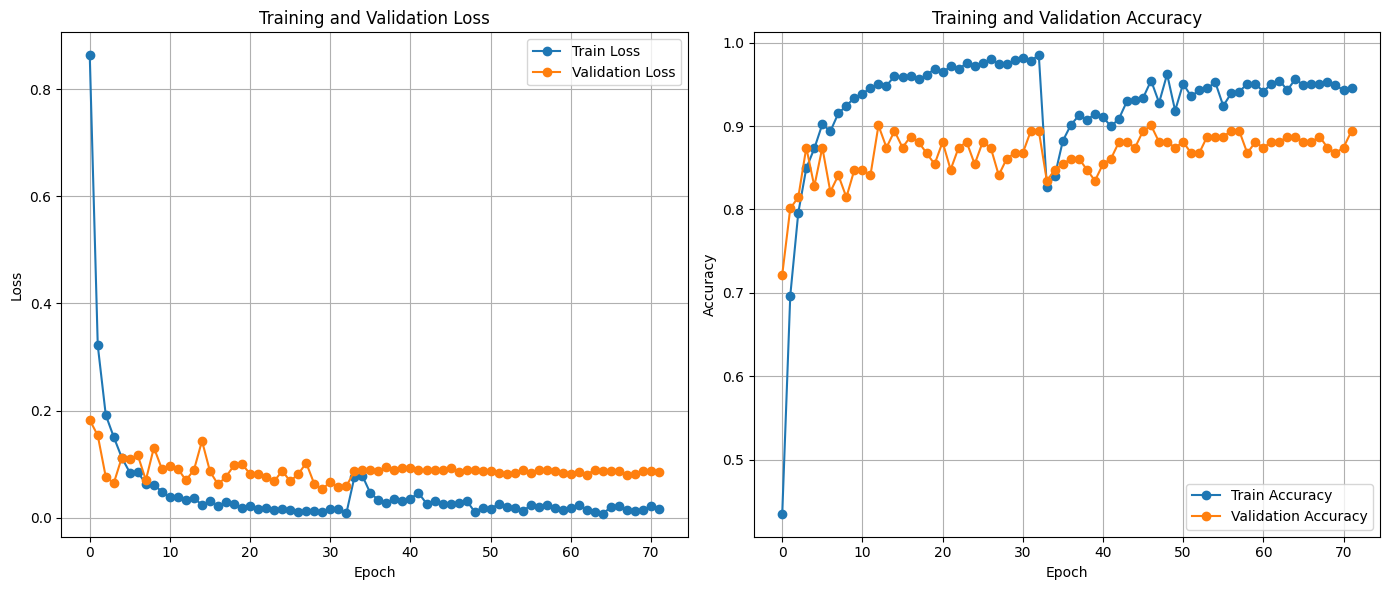

Evaluating: 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]



=== Test Set Evaluation ===
Test Loss: 0.2193

Classification Report:
              precision    recall  f1-score   support

  Chickenpox     0.7500    0.8571    0.8000         7
      Cowpox     0.8333    0.7143    0.7692         7
        HFMD     0.8333    0.9375    0.8824        16
     Healthy     1.0000    1.0000    1.0000        11
     Measles     0.6667    1.0000    0.8000         6
   Monkeypox     1.0000    0.8276    0.9057        29

    accuracy                         0.8816        76
   macro avg     0.8472    0.8894    0.8595        76
weighted avg     0.9002    0.8816    0.8838        76



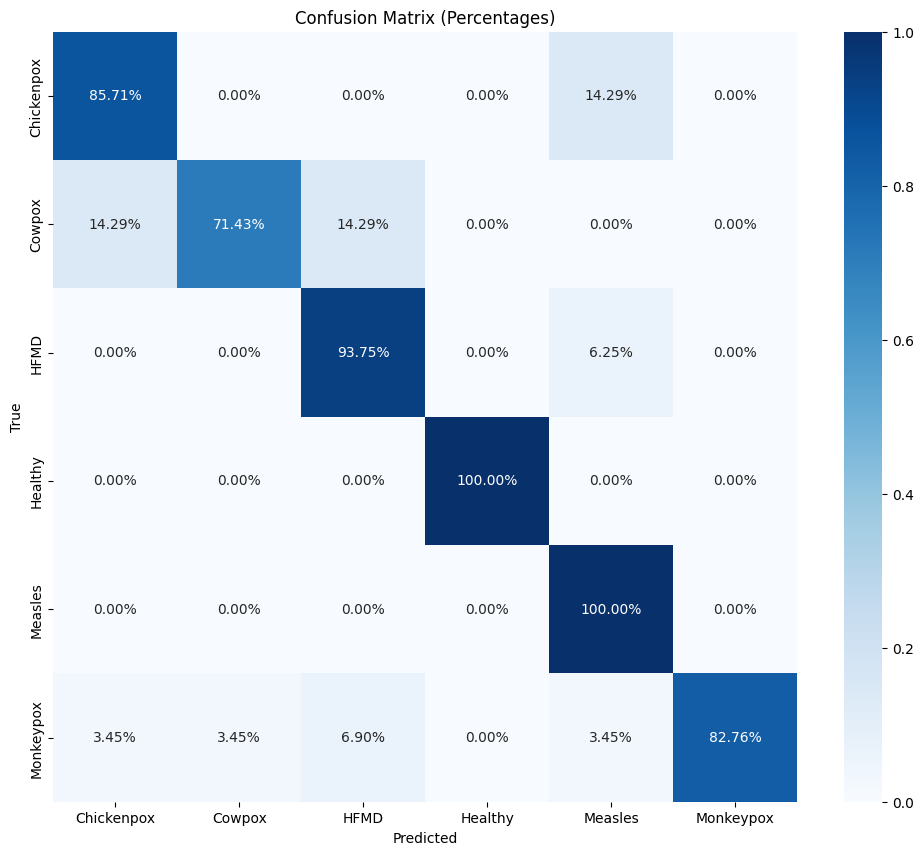


Class-wise Performance:
+------------+----------+---------+-------+-----------+---------+----------+
|   Class    | Accuracy | Correct | Total | Precision | Recall  | F1-score |
+------------+----------+---------+-------+-----------+---------+----------+
| Chickenpox |  85.71%  |    6    |   7   |  75.00%   | 85.71%  |  80.00%  |
|   Cowpox   |  71.43%  |    5    |   7   |  83.33%   | 71.43%  |  76.92%  |
|    HFMD    |  93.75%  |   15    |  16   |  83.33%   | 93.75%  |  88.24%  |
|  Healthy   | 100.00%  |   11    |  11   |  100.00%  | 100.00% | 100.00%  |
|  Measles   | 100.00%  |    6    |   6   |  66.67%   | 100.00% |  80.00%  |
| Monkeypox  |  82.76%  |   24    |  29   |  100.00%  | 82.76%  |  90.57%  |
+------------+----------+---------+-------+-----------+---------+----------+

Overall Accuracy: 88.16%


In [9]:
# Cell 9: Two-Stage Training with Focal Loss and Warm Restarts (Corrected Syntax)
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss)
        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss.sum()

def plot_training_history(history):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(history['val_acc'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, dataloader, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item() * inputs.size(0)
    
    avg_loss = total_loss / len(dataloader.dataset)
    return all_labels, all_preds, avg_loss

def mixup_data(x, y, alpha=0.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_model(model, criterion, optimizer, scheduler, num_epochs=150, mixup_alpha=0.0, patience=25, stage='minority'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    scaler = torch.amp.GradScaler('cuda')
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1} ({stage})')
        print('-' * 10)
        
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_size = inputs.size(0)
            
            optimizer.zero_grad()
            
            mixed_inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=mixup_alpha)
            
            with torch.amp.autocast('cuda'):
                outputs = model(mixed_inputs)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
                
                if torch.isnan(loss):
                    print(f"Warning: NaN loss detected in batch, skipping...")
                    continue
                
                _, preds = torch.max(outputs, 1)
                running_corrects += lam * torch.sum(preds == labels_a) + (1 - lam) * torch.sum(preds == labels_b)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * batch_size
            total_samples += batch_size
        
        model.eval()
        val_labels, val_preds, val_loss = evaluate_model(model, val_loader, criterion)
        val_acc = (np.array(val_preds) == np.array(val_labels)).mean()
        
        train_loss = running_loss / total_samples if total_samples > 0 else float('nan')
        train_acc = running_corrects.double() / total_samples if total_samples > 0 else 0.0
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc.cpu().numpy())
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        if scheduler is not None:
            scheduler.step()
        
        print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}\n')
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break
    
    print(f'Best validation Acc ({stage}): {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }

def evaluate_and_report(model, test_loader, test_dataset, criterion):
    test_labels, test_preds, test_loss = evaluate_model(model, test_loader, criterion)
    class_names = test_dataset.classes
    print("\n=== Test Set Evaluation ===")
    print(f"Test Loss: {test_loss:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)

    for label, pred in zip(test_labels, test_preds):
        class_correct[label] += (label == pred)
        class_total[label] += 1

    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(test_labels, test_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    precision = precision_score(test_labels, test_preds, average=None)
    recall = recall_score(test_labels, test_preds, average=None)
    f1 = f1_score(test_labels, test_preds, average=None)

    print("\nClass-wise Performance:")
    results = []
    for i in range(len(class_names)):
        if class_total[i] > 0:
            results.append({
                'Class': class_names[i],
                'Accuracy': f"{100 * class_correct[i] / class_total[i]:.2f}%",
                'Correct': class_correct[i],
                'Total': class_total[i],
                'Precision': f"{100 * precision[i]:.2f}%",
                'Recall': f"{100 * recall[i]:.2f}%",
                'F1-score': f"{100 * f1[i]:.2f}%"
            })

    results_df = pd.DataFrame(results)
    print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

    overall_acc = (np.array(test_labels) == np.array(test_preds)).mean()
    print(f"\nOverall Accuracy: {overall_acc * 100:.2f}%")
    return overall_acc

# Initialize model
model = MpoxCNN(num_classes=6).to(device)

# Class weights (corrected syntax)
class_counts = train['label'].value_counts().sort_index()
class_weights = 1.0 / torch.tensor([class_counts[cls] for cls in sorted(class_counts.index)], dtype=torch.float)
class_weights = torch.clamp(class_weights, max=20.0)
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights = class_weights.to(device)

criterion = FocalLoss(gamma=1.5, weight=class_weights, reduction='mean')

# Stage 1: Train with minority class focus
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.01,
    betas=(0.9, 0.999),
    eps=1e-6
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=50, T_mult=1, eta_min=1e-6
)

print("\n=== Stage 1: Minority Class Focus ===\n")
model, stage1_history = train_model(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=50,
    mixup_alpha=0.0,
    patience=20,
    stage='minority'
)

# Stage 2: Balanced fine-tuning with standard dataset
train_dataset = CustomSplitDataset(train, transform=data_transforms['train']['default'])
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-5,
    weight_decay=0.01,
    betas=(0.9, 0.999),
    eps=1e-6
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=50, T_mult=1, eta_min=1e-6
)

print("\n=== Stage 2: Balanced Fine-Tuning ===\n")
model, stage2_history = train_model(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=100,
    mixup_alpha=0.0,
    patience=25,
    stage='balanced'
)

# Combine histories for visualization
combined_history = {
    'train_loss': stage1_history['train_loss'] + stage2_history['train_loss'],
    'train_acc': stage1_history['train_acc'] + stage2_history['train_acc'],
    'val_loss': stage1_history['val_loss'] + stage2_history['val_loss'],
    'val_acc': stage1_history['val_acc'] + stage2_history['val_acc']
}
plot_training_history(combined_history)

# Evaluate
accuracy = evaluate_and_report(model, test_loader, test_dataset, criterion)

In [10]:
import torch
import os

# Cell: Save Model
def save_model(model, save_path="mpox_cnn_model.pth"):
    """
    Save the model's state dictionary to a file.
    
    Args:
        model: The trained PyTorch model to save
        save_path: File path to save the model (default: 'mpox_cnn_model.pth')
    """
    try:
        torch.save(model.state_dict(), save_path)
        print(f"Model successfully saved to {save_path}")
    except Exception as e:
        print(f"Error saving model: {str(e)}")

# Ensure the model is in evaluation mode
model.eval()

# Save the model
save_path = "mpox_cnn_model.pth"
save_model(model, save_path)

Model successfully saved to mpox_cnn_model.pth
